# Figure 3: benchmarking results
This script generates figure 3 of the paper, giving the semi-synthetic and cross-validation benchmarking results against comparator methods

### Before you start
This notebook assumes that the synthetic analysis and cross-validation analysis are already done and metrics have been computed and are located in `MCSPACE_paper/results`. 

Refer to the README in `MCSPACE_paper/scripts` for the analysis pipeline and more details.

In [24]:
from mcspace.utils import pickle_load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np

from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
import matplotlib.patches as mpatches

In [25]:
# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'

# Paths

Note: Paths are relative to this notebook, which is assumed to be located in `MCSPACE_paper/figures`

In [26]:
basepath = Path("./")
rootpath = Path("../../")

In [27]:
outpath = basepath / "paper_figures"
outpath.mkdir(exist_ok=True, parents=True)

## Paths to results
Given the analysis scripts have been run, the results should be located in the following paths

In [28]:
pwpath = rootpath / "MCSPACE_paper" / "results" / "pairwise"
mcpwpath = pwpath / "mcspace_results"
gmmpwpath = pwpath / "GMM_results"
fishpwpath = pwpath / "fisher_results"
ecopwpath = pwpath / "ecosim_results"
arrespath = rootpath / "MCSPACE_paper" / "results" / "assemblage_recovery"
cvpath = rootpath / "MCSPACE_paper" / "results" / "cross_validation"

# Load results

## pairwise results

In [29]:
fishpwres = pd.DataFrame(pickle_load(fishpwpath / "results.pkl"))
mcpwres = pd.DataFrame(pickle_load(mcpwpath / "results.pkl"))
ecopwres = pd.DataFrame(pickle_load(ecopwpath / "results.pkl"))
gmmpwres = pd.DataFrame(pickle_load(gmmpwpath / "results.pkl"))

# combine results
pwres = pd.concat([mcpwres, fishpwres, ecopwres, gmmpwres])

## assemblage recovery results

In [30]:
arres = pd.DataFrame(pickle_load(arrespath / "results.pkl"))

## cross validation results

In [31]:
cvres = pd.DataFrame(pickle_load(cvpath / "results.pkl"))

#### split CV results into human and mouse cases

In [32]:
all_cases = cvres['case'].unique()
mouse_cases = [x for x in all_cases if x.startswith('Mouse')]
human_cases = [x for x in all_cases if x.startswith('Human')]

human_res = cvres.loc[cvres['case'].isin(human_cases),:]
mouse_res = cvres.loc[cvres['case'].isin(mouse_cases),:]

# Render figure

In [33]:
def subset_results(res, subset_var, base_sample):
    temp = res.loc[res[subset_var] != 'default',:]
    temp = temp.loc[temp['base_sample'] == base_sample,:]
    return temp


def make_sub_gs_ax_cols(fig, gs,i,j, ncols, wspace=0.05):
    gssub = gs[i,j].subgridspec(1,ncols,wspace=wspace)
    axs = []
    for k in range(ncols):
        axs.append(fig.add_subplot(gssub[0,k]))
    return gssub, axs


def compute_corrected_pvalues(data, x, y, model_order, conditions, base='mcspace'):
    n_other = len(model_order) - 1
    n_conditions = len(conditions)
    pvalues = np.zeros((n_other, n_conditions))
    for i,mod in enumerate(model_order[1:]):
        for j, cond in enumerate(conditions):
            base_values = data.loc[(data['model'] == base) & (data[x] == cond),y].values
            comp_values = data.loc[(data['model'] == mod) & (data[x] == cond),y].values
            pval = mannwhitneyu(base_values, comp_values)
            pvalues[i,j] = pval.pvalue
    adjpvals = multipletests(pvalues.reshape((-1,)), alpha=0.05, method='fdr_bh')[1].reshape((n_other, n_conditions))
    return adjpvals


def annotate_pvalues(data, x, value, conditions, adjpvals, ax, h, width, text_h, offset, ns_h_shift):
    n_other, n_cond = adjpvals.shape

    # settings
    data_range = np.amax(data.loc[:,value].values) - np.amin(data.loc[:,value].values)
    
    STAR_SIZE = 12 #8
    NS_SIZE = 10
    LINEWIDTH = 1.0
    
    for i in range(n_other):
        for j, cond in enumerate(conditions):
            x1 = j - ((n_cond-1)/(2*n_cond)) + width
            x2 = x1 + 2*(i+1)*width #+ 0.01
            max_y = np.quantile(data.loc[data[x] == cond,value].values, q=0.99)
            y = max_y + i*offset + 0.025*data_range

            color = 'black'
            fontsize = STAR_SIZE
            text_h2 = text_h
            pv = adjpvals[i,j]
            if pv < 0.0001:
                levmarker = "****"
            elif pv < 0.001:
                levmarker = "***"
            elif pv < 0.01:
                levmarker = "**"
            elif pv < 0.05:
                levmarker = "*"
            else:
                levmarker = 'ns'
                color='tab:red'
                text_h2 = text_h - ns_h_shift
                fontsize = NS_SIZE
                
            ax.plot([x1, x1, x2, x2], [y+0.5*h, y+1.5*h, y+1.5*h, y+0.5*h], lw=LINEWIDTH, c=color)
            ax.text((x1+x2)*0.5, y+text_h2, levmarker, ha='center', va='bottom', color=color, fontsize=fontsize)
    return ax


def plot_case_results(ax, datasub, x, y, model_order, palette, base_sample):
#     datasub.fillna(1.0, inplace=True)
    ax=sns.boxplot(data=datasub, x=x, y=y, ax=ax, hue='model', 
                   hue_order=model_order, palette=palette, showfliers=False)
    ax=sns.stripplot(data=datasub, x=x, y=y, ax=ax, hue='model', 
               hue_order=model_order, palette=palette, dodge=True, edgecolor='k', linewidth=0.5, size=3)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.get_legend().remove()
    return ax


def plot_results(axs, data, cases, y, model_order, palette, base_sample, 
                 h=0.008, width=1.0/5.0, text_h=0.001, offset=0.02, ns_h_shift=0.01, grid=True):
#     cases = ['number particles', 'read depth', 'number clusters', 'contamination weight', 'number subjects']
    pvalsout = {}
    for i,case in enumerate(cases):
        datasub = subset_results(data, case, base_sample)
        datasub[case] = pd.to_numeric(datasub[case])
        axs[i]=plot_case_results(axs[i], datasub, case, y, model_order, palette, base_sample)
        conditions = np.sort(datasub[case].unique())
        pvals = compute_corrected_pvalues(datasub, x=case, y=y, model_order=model_order, conditions=conditions)
        pvalsout[case] = pvals
        axs[i] = annotate_pvalues(datasub, case, y, conditions, pvals, axs[i], h, width, text_h, offset, ns_h_shift)
        
        if grid:
            axs[i].set_axisbelow(True)
            axs[i].yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
            axs[i].set_axisbelow(True)
            axs[i].xaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')

    return axs, pvalsout


def box_to_ell_axes(ax):
    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)
    return ax 


def compute_corrected_pvalues_single_cond(data, x, y, model_order, base='mcspace'):
    n_other = len(model_order) - 1
    pvalues = np.zeros(n_other)
    for i,mod in enumerate(model_order[1:]):
        base_values = data.loc[(data['model'] == base),y].values
        comp_values = data.loc[(data['model'] == mod),y].values
        pval = mannwhitneyu(base_values, comp_values)
        pvalues[i] = pval.pvalue
    adjpvals = multipletests(pvalues, alpha=0.05, method='fdr_bh')[1]
    return adjpvals


def annotate_pvalues_single_cond(data, x, value, adjpvals, ax, h, width, text_h, offset):
    # settings
#     h=0.01
#     offset=0.05
#     width = 1.0
    STAR_SIZE = 12
    LINEWIDTH = 1.0
    
    n_other = len(adjpvals)
    
    for i in range(n_other):
        x1 = 0 
        x2 = x1 + (i+1)*width + 0.01
        max_y = 1.01*np.amax(data.loc[:,value].values)
        y = max_y + (i+0.5)*offset

        color = 'black'
        pv = adjpvals[i]
        if pv < 0.0001:
            levmarker = "****"
        elif pv < 0.001:
            levmarker = "***"
        elif pv < 0.01:
            levmarker = "**"
        elif pv < 0.05:
            levmarker = "*"
        else:
            levmarker = 'ns'
            color='tab:red'

        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=LINEWIDTH, c=color)
        ax.text((x1+x2)*0.5, y+text_h, levmarker, ha='center', va='bottom', color=color, fontsize=STAR_SIZE)
    return ax


def plot_results_combined(data, ax, palette, model_order, grid=True):
    ax=sns.boxplot(data=data, x='model', y='cosine distance', hue='model', ax=ax, 
                   palette=palette, order=model_order, linewidth=1, showfliers=False)
    if grid:
        ax.set_axisbelow(True)
        ax.yaxis.grid(True, 'major', linewidth=1, color='#e6e6e6')
    return ax



## settings

In [34]:
base_sample = 'Human'
cases = ['number particles', 'number reads']
case_names = ['Number of particles', 'Number of reads per particle']

In [35]:
pw_model_order = ['mcspace', 'fisher', 'SIM9', 'GMM']
ar_model_order = ['mcspace', 'gmm']
holdout_model_order = ['mcspace', 'gmm_basic', 'gmm_one_dim', 'gmm_two_dim']
grid=False

pw_palette = [sns.color_palette("colorblind")[i] for i in [0,1,2,4]]
ar_palette = [sns.color_palette("colorblind")[i] for i in [0,4]]
cv_palette = [sns.color_palette("colorblind")[i] for i in [0,4,7,8]]
full_palette = [sns.color_palette("colorblind")[i] for i in [0,1,2,4,7,8]]

labels = ['MCSPACE', "GMM", "d-GMM (1D)", "d-GMM (2D)"]
handles = []
for label, color in zip(labels,cv_palette):
    patch = mpatches.Patch(color=color, label=label)
    handles.append(patch)

# Plot figure

/tmp/ipykernel_213695/1337727307.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axar[0].set_yticklabels(axar[0].get_yticklabels(), fontsize=ticklabel_fontsize)
/tmp/ipykernel_213695/1337727307.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)
/tmp/ipykernel_213695/1337727307.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)
/tmp/ipykernel_213695/1337727307.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axnk[0].set_yticklabels(axnk[0].get_yticklabels(), fontsize=ti

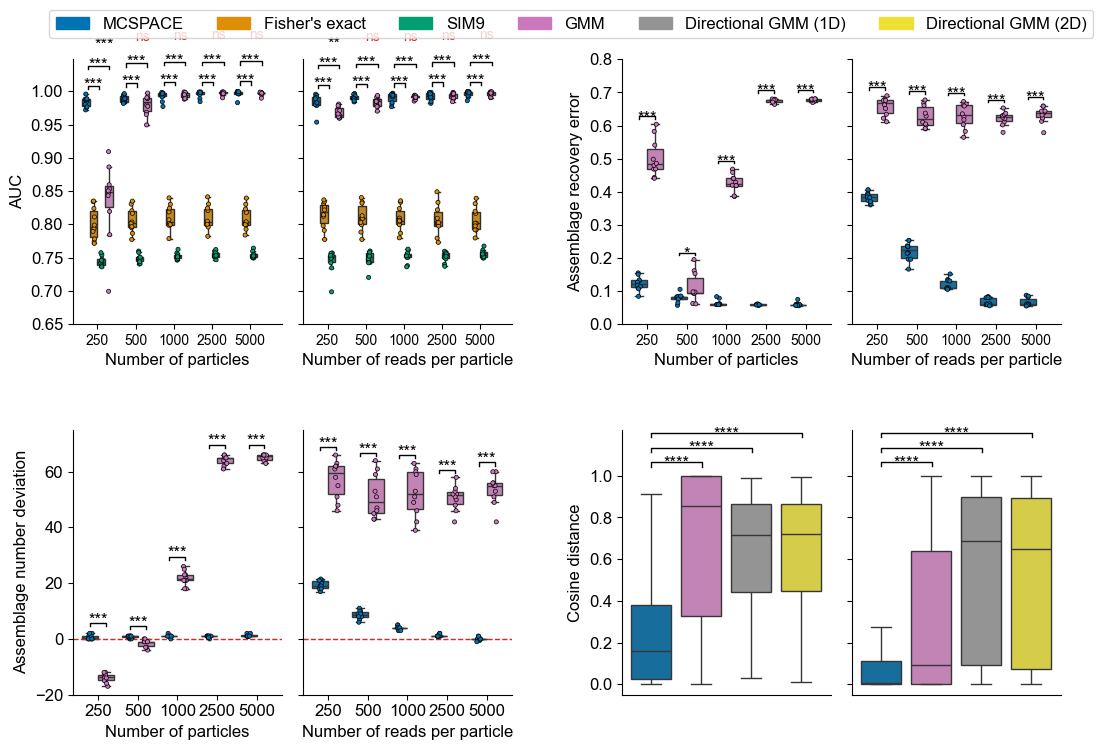

In [36]:
fontsize=12
label_fontsize=12
ticklabel_fontsize=12
rotation=0

scale = 1.5
fig = plt.figure(figsize=(scale*8.5,0.5*scale*11))
gs = fig.add_gridspec(ncols=2,nrows=2, wspace=0.25, hspace=0.4)

hspace = 0.2
wspace = 0.1
ncols =len(cases)
gspw, axpw = make_sub_gs_ax_cols(fig,gs,0,0,ncols,wspace)
gsar, axar = make_sub_gs_ax_cols(fig,gs,0,1,ncols,wspace)
gsnk, axnk = make_sub_gs_ax_cols(fig,gs,1,0,ncols,wspace)
gscv, axcv = make_sub_gs_ax_cols(fig,gs,1,1,ncols,wspace)

# plot pairwise results ======================================
axpw, pw_pvals = plot_results(axpw, pwres, cases, 'auc', pw_model_order, pw_palette, base_sample, 
                    width=1.0/7.0, text_h=-0.003, h=0.005, offset=0.03, ns_h_shift=-0.01, grid=grid)

for idx,ax in enumerate(axpw):
    ax.set_xlabel(case_names[idx], fontsize=fontsize)
    ax.set_ylim(0.65,1.048)
    ax.set_yticks(np.arange(0.65,1.001,0.05))
    ax=box_to_ell_axes(ax)
axpw[0].set_ylabel("AUC", fontsize=fontsize)
axpw[0].set_yticklabels(axpw[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axpw[1].set_yticklabels("") #labels(axpw[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axpw[1].set_ylabel("")

# plot comm err results ======================================
axar, ar_pvals = plot_results(axar, arres, cases, 'community error', ar_model_order, ar_palette, base_sample, text_h=-0.015, grid=grid)

for idx,ax in enumerate(axar):
    ax.set_xlabel(case_names[idx], fontsize=fontsize)
    ax.set_ylim(0,0.8)
    ax=box_to_ell_axes(ax)
axar[0].set_ylabel("Assemblage recovery error", fontsize=fontsize)
axar[0].set_yticklabels(axar[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axar[1].set_yticklabels("")
axar[1].set_ylabel("")


# plot nk err results ======================================
axnk, nk_pvals = plot_results(axnk, arres, cases, 'number clusters error', ar_model_order, ar_palette, base_sample, h=1.1, text_h=0, grid=grid)
for idx,ax in enumerate(axnk):
    ax.set_xlabel(case_names[idx], fontsize=fontsize)
    ax.axhline(y=0, color='tab:red', linestyle='--', linewidth=1)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=ticklabel_fontsize, rotation=rotation)

    ax.set_ylim(-20,75)
    ax=box_to_ell_axes(ax)
axnk[0].set_ylabel("Assemblage number deviation", fontsize=fontsize)
axnk[0].set_yticklabels(axnk[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axnk[1].set_yticklabels("")
axnk[1].set_ylabel("")


# cross validation
human_adjpvals = compute_corrected_pvalues_single_cond(human_res, x='model', y='cosine distance', model_order=holdout_model_order)
mouse_adjpvals = compute_corrected_pvalues_single_cond(mouse_res, x='model', y='cosine distance', model_order=holdout_model_order)

for ax, res, pv in zip(axcv, [human_res, mouse_res], [human_adjpvals, mouse_adjpvals]):
    ax = plot_results_combined(res, ax, cv_palette, holdout_model_order, grid=False)
    ax = annotate_pvalues_single_cond(res,'model','cosine distance', pv, ax,
                                         h=0.02, width=1, text_h=-0.02, offset=0.07)
    ax = box_to_ell_axes(ax)
    ax.set_ylim(-0.05,1.22)
    ax.set_yticks(np.arange(0,1.001,0.2))
    ax.set_xticks([])
    ax.set_xlabel("")
axcv[0].set_ylabel("Cosine distance", fontsize=fontsize)
axcv[0].set_yticklabels(axcv[0].get_yticklabels(), fontsize=ticklabel_fontsize)
axcv[1].set_yticklabels("")
axcv[1].set_ylabel("")


# Legend
labels = ['MCSPACE',"Fisher's exact", 'SIM9', "GMM", "Directional GMM (1D)", "Directional GMM (2D)"]
handles = []
for label, color in zip(labels,full_palette):
    patch = mpatches.Patch(color=color, label=label)
    handles.append(patch)
    
L=fig.legend(handles=handles, loc='upper left', ncols=6, bbox_to_anchor=(0.1,0.95), fontsize=fontsize)
plt.setp(L.get_title(),fontsize=fontsize)
plt.savefig(outpath / "figure3_benchmarking_results.svg", bbox_inches="tight")